In [1]:
import numpy as np
from utils import Reader, FourierReader
from graph_utils import random_walk_pooling
import os, sys
import ctypes as ct
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

reader = Reader(is_test=True)

----------------POINT CLOUD READER------------------
Reader initialized in directory: /home/zcx/Documents/datasets/ModelNet/
Files loaded: 2
Data loaded: 2468
Data shape: (2048, 3)
----------------------------------------------------


(2048, 3)
[[ 5.8207661e-11 -1.8411583e-08 -4.4128683e-08]]
(2048, 3)
[ 5.8207661e-11 -8.5469765e-10  1.1714292e-09] [-2.2118911e-09 -1.6589183e-09  0.0000000e+00]


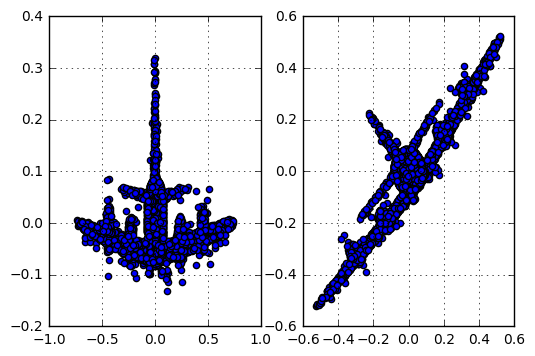

In [3]:
def rotate(points, theta, phi=0):
    rat = np.zeros_like(points)
    rat[:, 0] = points[:, 0] * math.cos(theta) - math.sin(theta) * points[:, 1]
    rat[:, 1] = points[:, 0] * math.sin(theta) + math.sin(theta) * points[:, 1]
#     rat[:, 1] = rat[:, 1] * math.cos(theta) - math.sin(theta) * rat[:, 2]
#     rat[:, 2] = rat[:, 1] * math.sin(theta) + math.sin(theta) * rat[:, 2]
    return rat

xs, ys = reader.next_batch(1)
xs = xs[0]
print(xs.shape)
mean_p = xs.mean(axis=0, keepdims=True)
print(mean_p)
xs -= mean_p
print(xs.shape)
rat = rotate(xs, math.pi/4.0, math.pi/4.0)
print(xs.mean(axis=0), rat.mean(axis=0))

plt.close()
plt.figure()
plt.subplot(121)
plt.scatter(xs[:, 0], xs[:, 1])
plt.grid()
plt.subplot(122)
plt.scatter(rat[:, 0], rat[:, 1])
plt.grid()
plt.show()

In [22]:
fre = np.fft.fft(xs)
print(fre.shape, fre.mean(), fre.dtype)
tim = np.fft.ifft(fre).real

(2048, 3) (1.6471418007313332e-08+3.614007241618348e-19j) complex128
0.0


In [5]:
pts, _ = reader.next_batch(1)
pts = pts[0, :, :]
rot = rotate(pts, math.pi/2.5)

expr = np.zeros((2048), dtype=complex)
expr.real = pts[:, 0]
expr.imag = pts[:, 1]

ipts = np.fft.ifft(expr).real

expr_rot = np.zeros((2048), dtype=complex)
expr_rot.real = rot[:, 0]
expr_rot.imag = rot[:, 1]
irot = np.fft.ifft(expr).real

print(ipts[: 10], ipts.mean(), ipts.var())
print(irot[: 10], irot.mean(), ipts.var())

[-1.61450830e-09  2.03719634e-04  6.19014776e-03 -1.88904705e-03
  3.26515173e-03 -5.09610445e-03  1.83622420e-04 -5.86704401e-04
  6.01192792e-03  6.98422428e-03] -2.679912358871655e-05 4.227175377280698e-05
[-1.61450830e-09  2.03719634e-04  6.19014776e-03 -1.88904705e-03
  3.26515173e-03 -5.09610445e-03  1.83622420e-04 -5.86704401e-04
  6.01192792e-03  6.98422428e-03] -2.679912358871655e-05 4.227175377280698e-05


In [67]:
xs, ys = reader.next_batch(1)
print(xs.mean(), xs.max(), xs.min())

-5.2774944e-09 0.9403619 -0.9259565


In [2]:
# Preprocessing

def convert_to_fourier(idx):
    data_arr, ys_arr = reader.Data(idx)
    print('Data array shape: ', data_arr.shape, ys_arr.shape)
    fourier_ls = list()
    for it in range(data_arr.shape[0]):
        slicer = data_arr[it, :, :]
        xy_plane = np.zeros((2048), dtype=complex)
        xy_plane.real = slicer[:, 0]
        xy_plane.imag = slicer[:, 1]
        yz_plane = np.zeros((2048), dtype=complex)
        yz_plane.real = slicer[:, 1]
        yz_plane.imag = slicer[:, 2]
        xz_plane = np.zeros((2048), dtype=complex)
        xz_plane.real = slicer[:, 0]
        xz_plane.imag = slicer[:, 2]
        xy_real = np.fft.ifft(xy_plane).real[:, None]
        yz_real = np.fft.ifft(yz_plane).real[:, None]
        xz_real = np.fft.ifft(xz_plane).real[:, None]
        fourier = np.concatenate([xy_real, yz_real, xz_real], axis=1)[None, :, :]
        fourier /= fourier.var()
        fourier_ls.append(fourier)
        if it % 64 == 32:
            print(it, end=' ')

    fourier_arr = np.concatenate(fourier_ls, axis=0)
    print(fourier_arr.shape)
    filename = 'fourier_test{}.npy'.format(idx)
    np.save(filename, fourier_arr)
    print('Finished!')
    
for it in range(2):
    convert_to_fourier(it)

Data array shape:  (2048, 2048, 3) (2048, 1)
32 96 160 224 288 352 416 480 544 608 672 736 800 864 928 992 1056 1120 1184 1248 1312 1376 1440 1504 1568 1632 1696 1760 1824 1888 1952 2016 (2048, 2048, 3)
Finished!
Data array shape:  (420, 2048, 3) (420, 1)
32 96 160 224 288 352 416 (420, 2048, 3)
Finished!


In [81]:
from utils import Reader, FourierReader

reader = FourierReader(is_test=True)


(2048, 3) float64
